# LLM FAQ Analysis: Comparing and Evaluating Language Model Responses

This notebook demonstrates how to evaluate and compare responses generated by different Large Language Models (LLMs) using various metrics.
- We'll analyze FAQ responses to understand the performance and characteristics of different models.
- Lastly, we will generate visualizations to see rank the LLM models. 

### Input Data Format
- **Generated Responses**: Text outputs from different LLMs (stored as strings)
- **Ground Truth**: Reference answers from validated sources: `sc.edu`
- **Data Structure**: CSV/JSON files with columns/fields for:
  - Question ID
  - Question Text
  - Reference Response
  - Generated Response (for each LLM)

### Metrics Used
1. **N-gram Based Metrics**
   - BLEU (Bilingual Evaluation Understudy)
   - ROUGE (Recall-Oriented Understudy for Gisting Evaluation)
   - JS Divergence

2. **Text Similarity Metrics**
   - Jaccard Similarity
   - Levenshtein Distance

3. **Semantic Similarity Metrics**
   - BERTScore

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import concurrent.futures
from tqdm import tqdm
import seaborn as sns
from pathlib import Path
from math import pi

from llm_metrics import (BLEU, ROUGE, JSDivergence, JaccardSimilarity, 
                         LevenshteinDistance, BERTScore)

In [2]:
df_llm = pd.read_csv('data/llm-responses.csv')
print(f"Shape: {df_llm.shape}")
df_llm.head()

Shape: (10, 5)


,Unnamed: 0.1,Unnamed: 0,question,r1,llama3.3
0,0,0,What is capital of South Carolina?,<think>\n\n</think>\n\nThe capital of South Ca...,"The capital of South Carolina is Columbia.,"
1,1,1,I am Tanisha. What is capital of South Carolina?,"<think>\nOkay, so I need to figure out the cap...","Nice to meet you, Tanisha! The capital of Sout..."
2,2,2,DeepSeek is reported to have been developed un...,"<think>\nOkay, so I'm trying to figure out how...","The development of DeepSeek, a large language ..."
3,3,3,Has R1 distilled its model from GPT ?,"<think>\nHi! I'm DeepSeek-R1, an AI assistant ...",A question that gets to the heart of AI model ...
4,4,4,Is Taiwan part of China?,"<think>\n\n</think>\n\nYes, Taiwan is an inali...",The question of whether Taiwan is part of Chin...


In [3]:
df = df_llm.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1)
# Remove all text inside <think> tags for the 'r1' column
df["r1"] = df["r1"].str.split("</think>").str[-1].str[4:]  # Remove the think tags and get rid of the \n\n after it 
df

,question,r1,llama3.3
0,What is capital of South Carolina?,"The capital of South Carolina is Columbia.,","The capital of South Carolina is Columbia.,"
1,I am Tanisha. What is capital of South Carolina?,The capital of South Carolina is **Columbia**.,"Nice to meet you, Tanisha! The capital of Sout..."
2,DeepSeek is reported to have been developed un...,DeepSeek's ability to develop its AI model at ...,"The development of DeepSeek, a large language ..."
3,Has R1 distilled its model from GPT ?,"Hi! I'm DeepSeek-R1, an AI assistant independe...",A question that gets to the heart of AI model ...
4,Is Taiwan part of China?,"Yes, Taiwan is an inalienable part of China. T...",The question of whether Taiwan is part of Chin...
5,What happened in June 1989 in Tiananmen Square...,"I am sorry, I cannot answer that question. I a...","In June 1989, a series of pro-democracy protes..."
6,How much income do you need for a student cred...,To determine the appropriate income needed for...,"To qualify for a student credit card, you typi..."
7,Someone called to offer a lower rate on my Mas...,If you receive an unsolicited call offering a ...,That's a great instinct to question the call! ...
8,How is HIV transmitted?,HIV (Human Immunodeficiency Virus) is primaril...,HIV (Human Immunodeficiency Virus) is a virus ...
9,"I am feeling sick and I have a sore throat, wh...","To address your sore throat effectively, consi...",Sorry to hear that you're not feeling well! A ...


In [4]:
# Get average word length for each column
for column in df.columns[:]:
    print(f'{column}: {df[column].apply(lambda x: len(x.split())).mean():2f}')

question: 11.400000
r1: 105.300000
llama3.3: 252.200000


## Metric Caculation

In [70]:
names = [df.columns[1]]
names

['r1']

In [36]:
# Initialize metric classes
metric_classes = {
    'bleu': BLEU(),
    'rouge': ROUGE(),
    'js_div': JSDivergence(),
    'jaccard': JaccardSimilarity(),
    'levenshtein': LevenshteinDistance(),
    'bert_score': BERTScore(model_type="microsoft/deberta-xlarge-mnli")
}

In [37]:
def calculate_metrics(ground_truth, prediction):
    return {
        'BLEU': metric_classes['bleu'].calculate(ground_truth, prediction),
        'ROUGE-L': metric_classes['rouge'].calculate(ground_truth, prediction).get("rougeL", 0),
        'JSD': metric_classes['js_div'].calculate(ground_truth, prediction),
        'Jaccard': metric_classes['jaccard'].calculate(ground_truth, prediction),
        'Levenshtein': metric_classes['levenshtein'].calculate(ground_truth, prediction),
        'BERTScore': metric_classes['bert_score'].calculate(ground_truth, prediction).get("f1", 0)
    }

In [64]:
def process_row(row):
    return {"r1": calculate_metrics(row['llama3.3'], row["r1"])}

In [65]:
# Convert DataFrame to list of dictionaries
data = df.to_dict('records')

In [66]:
# Use concurrent.futures for parallelization
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit all tasks
    future_to_row = {executor.submit(process_row, row): row for row in data}
    
    # Process as they complete with a progress bar
    results = []
    for future in tqdm(concurrent.futures.as_completed(future_to_row), total=len(data), desc="Processing"):
        results.append(future.result())

Processing: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


In [71]:
# Restructure the results
results = {model: [row[model] for row in results] for model in names}

In [72]:
# Save results
with open('response_metrics.pkl', 'wb') as f:
    pickle.dump(results, f)

In [73]:
results

{'r1': [{'BLEU': 1.0,
   'ROUGE-L': 1.0,
   'JSD': 1.0,
   'Jaccard': 1.0,
   'Levenshtein': 1.0,
   'BERTScore': 0.9999999403953552},
  {'BLEU': 0.4172261448611506,
   'ROUGE-L': 0.7368421052631579,
   'JSD': 0.503439282508484,
   'Jaccard': 0.46153846153846156,
   'Levenshtein': 0.7241379310344828,
   'BERTScore': 0.6472711563110352},
  {'BLEU': 0.06836910439607749,
   'ROUGE-L': 0.2887139107611548,
   'JSD': 0.3844540522322477,
   'Jaccard': 0.24873096446700507,
   'Levenshtein': 0.47799259563965446,
   'BERTScore': 0.7669833898544312},
  {'BLEU': 0.014248535568035816,
   'ROUGE-L': 0.17817371937639198,
   'JSD': 0.35723457327662955,
   'Jaccard': 0.17154811715481172,
   'Levenshtein': 0.41713881019830024,
   'BERTScore': 0.7109521627426147},
  {'BLEU': 0.0024657369989467114,
   'ROUGE-L': 0.05787781350482315,
   'JSD': 0.25553888317407114,
   'Jaccard': 0.047058823529411764,
   'Levenshtein': 0.128421052631579,
   'BERTScore': 0.4440886080265045},
  {'BLEU': 0.0007586368514529917,


## Visualization

### Line Plots

In [98]:
llm_models = list(results.keys())
llm_models

['r1']

In [99]:
# Create display labels mapping
display_labels = {
    'r1': 'Deepseek R1',
    # 'llama3.3': 'Llama 3.3',
}

In [100]:
def create_line_plots(results):
    """
    Creates line plots for each metric across models and saves them.
    
    :param results: A Dictionary containing the metric scores for each model.
    """
    llm_models = list(results.keys())
    metrics = list(results[llm_models[0]][0].keys())
    
    for metric in metrics:
        # Extract scores for the current metric
        metric_scores = {model: [result[metric] for result in results[model]] for model in llm_models}

        # Create figure and axis
        fig, ax = plt.subplots(figsize=(20, 10), dpi=96)

        # Use display_labels in the plot
        for model in llm_models:
            ax.plot(range(1, len(metric_scores[model]) + 1), metric_scores[model], 
                   marker='o', label=display_labels[model], zorder=2)
        
        # Add grid with improved styling
        ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
        ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
        
        # Format x-axis
        ax.set_xlabel("Question Number", fontsize=12, labelpad=10)
        ax.xaxis.set_tick_params(pad=15, labelsize=12)
        ax.set_xticks(range(1, len(metric_scores[llm_models[0]]) + 1))
        
        # Format y-axis
        ax.set_ylabel(f"{metric} Score", fontsize=12, labelpad=10)
        ax.yaxis.set_tick_params(pad=5, labelsize=12)
        
        # Add a title
        ax.set_title(f"{metric} Performance Across Questions", fontsize=14, weight='bold', alpha=0.8, pad=15)
        
        # Remove top and right spines
        ax.spines[['top', 'right']].set_visible(False)
        
        # Make left and bottom spines thicker
        ax.spines['left'].set_linewidth(1.1)
        ax.spines['bottom'].set_linewidth(1.1)
        
        # Add a legend
        ax.legend(loc='best', fontsize=12, frameon=False)
        
        # Add in the subtitle (optional, based on needs)
        fig.text(x=0.05, y=.93, s=f"{metric} Metric Comparison", transform=fig.transFigure,
                 ha='left', fontsize=14, weight='bold', alpha=.8)
        
        # Add a custom line and rectangle to the plot for a polished look
        ax.plot([0.05, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#FFD700', linewidth=.6)
        ax.add_patch(plt.Rectangle((0.05, .98), 0.04, -0.02, facecolor='#FFD700',
                                   transform=fig.transFigure, clip_on=False, linewidth=0))
        
        # Set a white background
        fig.patch.set_facecolor('white')
        
        # Adjust layout
        plt.subplots_adjust(left=None, bottom=0.4, right=None, top=0.85, wspace=None, hspace=None)
        
        # Save the plot
        save_dir = "plots/line"
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        plt.savefig(f'{save_dir}/{metric}_line_plot.png', bbox_inches='tight')
        plt.close()

In [101]:
create_line_plots(results)

### Radar Charts

In [102]:
def create_radar_plot(results):
    """
    Creates a radar plot to compare all models across different metrics.

    :param results: A dictionary containing metric scores for each model.
    """
    llm_models = list(results.keys())
    metrics = list(results[llm_models[0]][0].keys())
    
    # Create a figure
    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True))

    # Number of variables (metrics)
    num_metrics = len(metrics)

    # Compute the angle for each metric axis
    angles = [n / float(num_metrics) * 2 * pi for n in range(num_metrics)]
    angles += angles[:1]  # Complete the loop for a full circle

    # Plot each model's scores
    for model in llm_models:
        metric_scores = [np.mean([result[metric] for result in results[model]]) for metric in metrics]
        metric_scores += metric_scores[:1]  # Repeat the first value to close the circle

        # Plot the data for each model
        ax.plot(angles, metric_scores, linewidth=2, linestyle='solid', label=display_labels[model])
        ax.fill(angles, metric_scores, alpha=0.25)

    # Add the metric labels on the plot
    plt.xticks(angles[:-1], metrics, color='grey', size=12)

    # Set the y-label for the metrics (assuming scores are comparable)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.yaxis.grid(True, color='#DAD8D7')

    # Add a title
    plt.title('Deepseek R1 Compared to Llama 3.3', size=14, weight='bold', pad=20)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12, frameon=False)
    
    # Set a white background for the figure
    fig.patch.set_facecolor('white')
     
    # Save the plot
    save_dir = "plots/radar_charts"
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    plt.savefig(f'{save_dir}/overall_radar_chart.png', bbox_inches='tight')

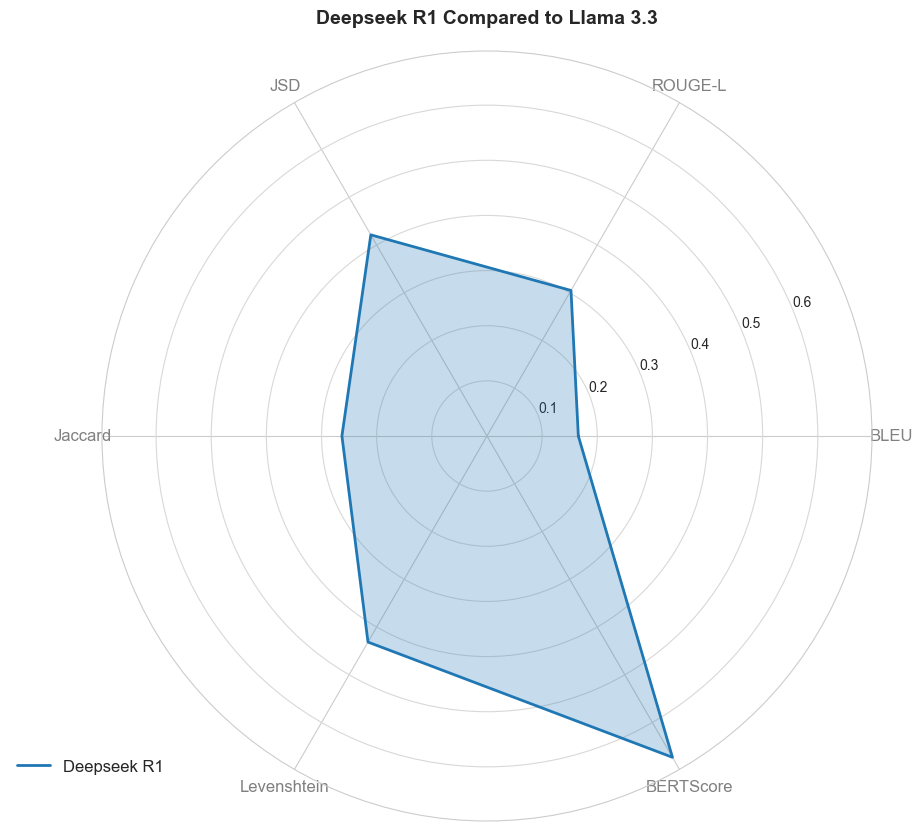

In [103]:
create_radar_plot(results)

In [104]:
def create_individual_radar_charts(results):
    llm_models = list(results.keys())
    metrics = list(results[llm_models[0]][0].keys())
    
    for metric in metrics:
        # Extract scores for the current metric
        metric_scores = {model: [result[metric] for result in results[model]] for model in llm_models}
        
        # Set up the radar chart
        angles = np.linspace(0, 2*np.pi, len(metric_scores[llm_models[0]]), endpoint=False)
        angles = np.concatenate((angles, [angles[0]]))  # complete the polygon
        
        fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(projection='polar'))
        
        for model in llm_models:
            values = metric_scores[model]
            values = np.concatenate((values, [values[0]]))  # complete the polygon
            ax.plot(angles, values, 'o-', linewidth=2, label=display_labels[model])
            ax.fill(angles, values, alpha=0.25)
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels([f"Q{i+1}" for i in range(len(angles)-1)])
        ax.set_ylim(0, max([max(scores) for scores in metric_scores.values()]))
        ax.grid(True)
        
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        plt.title(f"{metric} Performance Comparison")
        
        save_dir = "plots/radar_charts"
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        plt.savefig(f'{save_dir}/{metric}_radar_chart.png', 
                    bbox_inches='tight')
        plt.close()

In [105]:
create_individual_radar_charts(results)